In [3]:
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
import torch

import sys, os
sys.path.append(os.path.abspath('..'))
from models.subpix_rcnn import SubpixRCNN
from utils import move_data_to_device, move_dict_to_cpu, plot_image_boxes, evaluate_predictions
from PsfSimulator import PsfDataset
from scripts.plotting import PlotController
from scripts.evaluating import test_densities_fixed_snr, test_model_once_plot, evaluate_recall_per_snr, test_perlinnoise_fixed_snr
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [2]:
seed = None
num_datapoints = 1
num_spots_min = 1
num_spots_max = 1
sigma_mean= 1.0
sigma_std = 0.1
snr_min = 5
snr_max = 5
snr_std = 0.0
base_noise_min = 50
base_noise_max = 6000
use_gauss_noise = False
gauss_noise_std = 0.02
use_perlin_noise = False
perlin_min_max = (0.4, 0.6)
img_w = 64
img_h = 64

dataset = PsfDataset(seed, num_datapoints, num_spots_min, num_spots_max, sigma_mean, sigma_std,
                      snr_min, snr_max, snr_std, base_noise_min, base_noise_max, use_gauss_noise,
                      gauss_noise_std, use_perlin_noise, perlin_min_max, img_w, img_h)



In [4]:
device = 'cuda'
backbone = resnet_fpn_backbone("resnet50", pretrained=False, trainable_layers=5)
kwargs = {"nms_thresh": 0.1, "detections_per_img": None, "score_thresh": 0.7, "image_mean":[0,0,0], "image_std":[1,1,1]}
model = SubpixRCNN(backbone, num_classes=2, device=device, **kwargs)
model.to(device=device)
path = r"D:\zeiss\Desktop\coding\Hilger\bachelor\notebooks\subpix_rcnn_models\2025-05-28_08-57-04\threehrsperlin.pth"
model.load_state_dict(torch.load(path, map_location=device))
model.eval()

c:\Users\zeiss\anaconda3\envs\hilger312\Lib\site-packages\torchvision\models\_utils.py:135: UserWarning: Using 'backbone_name' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
c:\Users\zeiss\anaconda3\envs\hilger312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\zeiss\anaconda3\envs\hilger312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Custom SubpixRoIHeads successfully initialized!


SubpixRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0, 0, 0], std=[1, 1, 1])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu): ReLU(inplace=True)
  

In [ ]:
result = evaluate_recall_per_snr(model, 20000, device, 0.5, **params)
params = {'snr_min': 1, 'snr_max': 10}


Processing image 1/20000
Processing image 101/20000
Processing image 201/20000
Processing image 301/20000
Processing image 401/20000
Processing image 501/20000
Processing image 601/20000
Processing image 701/20000
Processing image 801/20000
Processing image 901/20000
Processing image 1001/20000
Processing image 1101/20000
Processing image 1201/20000
Processing image 1301/20000
Processing image 1401/20000
Processing image 1501/20000
Processing image 1601/20000
Processing image 1701/20000
Processing image 1801/20000
Processing image 1901/20000
Processing image 2001/20000
Processing image 2101/20000
Processing image 2201/20000
Processing image 2301/20000
Processing image 2401/20000
Processing image 2501/20000
Processing image 2601/20000
Processing image 2701/20000
Processing image 2801/20000
Processing image 2901/20000
Processing image 3001/20000
Processing image 3101/20000
Processing image 3201/20000
Processing image 3301/20000
Processing image 3401/20000
Processing image 3501/20000
Proc

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import copy

In [ ]:

snrs = np.array(list(result05[0].keys()))
recalls = np.array([result05[0][snr]['TP'] / (result05[0][snr]['TP'] + result05[0][snr]['FN']) for snr in snrs])
plt.scatter(snrs, recalls)
plt.xlabel('SNR')
plt.ylabel('Recall')
plt.title('Recall vs SNR')
plt.xlim(1,7)
plt.grid()
plt.show()

# Maybe interesting to show for different background noise levels? Different score_thresh?

NameError: name 'result' is not defined

In [18]:
print(type(result))

<class 'collections.defaultdict'>


In [20]:
import pickle
result_dict = dict(result)
save_path = r'd:\zeiss\Desktop\coding\Hilger\bachelor\recall_vs_snr_widerangeofbg.pkl'

with open(save_path, 'wb') as f:
    pickle.dump(result_dict, f)

In [3]:
denseresults2snr = test_densities_fixed_snr(model, snr=2, num_images=300, device=device)
denseresults3snr = test_densities_fixed_snr(model, snr=3, num_images=300, device=device)
denseresults5snr = test_densities_fixed_snr(model, snr=5, num_images=300, device=device)
denseresults8snr = test_densities_fixed_snr(model, snr=8, num_images=300, device=device)

0.5
Density: 0.04, Metrics: {'mean_precision': np.float64(0.2803333333333333), 'mean_recall': np.float64(0.3933333333333333), 'mean_f1': np.float64(0.31255555555555553), 'mean_ji': np.float64(0.2803333333333333), 'mean_loc_error': np.float64(nan), 'avg_std_loc_error': np.float64(nan), 'mean_mean_squared_error': np.float64(nan), 'avg_std_mean_squared_error': np.float64(nan), 'std_precision': np.float64(0.39459106821000284), 'std_recall': np.float64(0.4884897360459299), 'std_f1': np.float64(0.41174622113297404), 'std_ji': np.float64(0.39459106821000284), 'std_loc_error': np.float64(nan), 'std_mean_squared_error': np.float64(nan)}


c:\Users\zeiss\anaconda3\envs\hilger312\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\zeiss\anaconda3\envs\hilger312\Lib\site-packages\numpy\_core\_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\zeiss\anaconda3\envs\hilger312\Lib\site-packages\numpy\_core\_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\zeiss\anaconda3\envs\hilger312\Lib\site-packages\numpy\_core\_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\zeiss\anaconda3\envs\hilger312\Lib\site-packages\numpy\_core\_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.5
Density: 0.05, Metrics: {'mean_precision': np.float64(0.4068968253968254), 'mean_recall': np.float64(0.42833333333333334), 'mean_f1': np.float64(0.39884656084656084), 'mean_ji': np.float64(0.3028333333333333), 'mean_loc_error': np.float64(nan), 'avg_std_loc_error': np.float64(nan), 'mean_mean_squared_error': np.float64(nan), 'avg_std_mean_squared_error': np.float64(nan), 'std_precision': np.float64(0.35100346908707536), 'std_recall': np.float64(0.33768410616366823), 'std_f1': np.float64(0.31373881638005546), 'std_ji': np.float64(0.282111466675195), 'std_loc_error': np.float64(nan), 'std_mean_squared_error': np.float64(nan)}
0.5
Density: 0.060000000000000005, Metrics: {'mean_precision': np.float64(0.4193650793650794), 'mean_recall': np.float64(0.4666666666666667), 'mean_f1': np.float64(0.4245978835978836), 'mean_ji': np.float64(0.3303611111111111), 'mean_loc_error': np.float64(nan), 'avg_std_loc_error': np.float64(nan), 'mean_mean_squared_error': np.float64(nan), 'avg_std_mean_squar

d:\zeiss\Desktop\coding\Hilger\bachelor\PsfSimulator.py:122: RuntimeWarning: All-NaN slice encountered
  signal = np.nanmax(array[y1:y2, x1:x2])


0.5
Density: 0.5, Metrics: {'mean_precision': np.float64(0.5065090554297211), 'mean_recall': np.float64(0.35050000000000003), 'mean_f1': np.float64(0.41149291724143333), 'mean_ji': np.float64(0.26591812819991023), 'mean_loc_error': np.float64(0.34124552578882583), 'avg_std_loc_error': np.float64(0.12283493925004904), 'mean_mean_squared_error': np.float64(0.13569010804033127), 'avg_std_mean_squared_error': np.float64(0.08175572115324084), 'std_precision': np.float64(0.1323828820437509), 'std_recall': np.float64(0.1101880967558051), 'std_f1': np.float64(0.1167309163767811), 'std_ji': np.float64(0.09402243661707384), 'std_loc_error': np.float64(0.054472201677919455), 'std_mean_squared_error': np.float64(0.03604361202275668)}
0.5
Density: 0.6, Metrics: {'mean_precision': np.float64(0.5077064748403758), 'mean_recall': np.float64(0.33597222222222217), 'mean_f1': np.float64(0.40198693998837265), 'mean_ji': np.float64(0.2569956778870638), 'mean_loc_error': np.float64(0.3444830748345202), 'avg_

d:\zeiss\Desktop\coding\Hilger\bachelor\PsfSimulator.py:129: RuntimeWarning: All-NaN slice encountered
  meanbg = np.nanmedian(array[y1:y2, x1:x2])


0.5
Density: 4.0, Metrics: {'mean_precision': np.float64(0.45704740487714657), 'mean_recall': np.float64(0.10959100204498978), 'mean_f1': np.float64(0.1763302137967518), 'mean_ji': np.float64(0.09709625046492068), 'mean_loc_error': np.float64(0.35034827634017923), 'avg_std_loc_error': np.float64(0.13659249326911), 'mean_mean_squared_error': np.float64(0.14294427622076727), 'avg_std_mean_squared_error': np.float64(0.0940312541160513), 'std_precision': np.float64(0.07780565305159927), 'std_recall': np.float64(0.023305877395942618), 'std_f1': np.float64(0.03504133637608593), 'std_ji': np.float64(0.02116249709033113), 'std_loc_error': np.float64(0.03470107323390984), 'std_mean_squared_error': np.float64(0.02381281762378104)}
0.5
Density: 0.04, Metrics: {'mean_precision': np.float64(0.5562222222222223), 'mean_recall': np.float64(0.73), 'mean_f1': np.float64(0.6068888888888889), 'mean_ji': np.float64(0.5562222222222223), 'mean_loc_error': np.float64(nan), 'avg_std_loc_error': np.float64(nan)

In [26]:
denseresults2snr = test_densities_fixed_snr(model, snr=2, num_images=300, device=device)

c:\Users\zeiss\anaconda3\envs\hilger312\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\zeiss\anaconda3\envs\hilger312\Lib\site-packages\numpy\_core\_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\zeiss\anaconda3\envs\hilger312\Lib\site-packages\numpy\_core\_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\zeiss\anaconda3\envs\hilger312\Lib\site-packages\numpy\_core\_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\zeiss\anaconda3\envs\hilger312\Lib\site-packages\numpy\_core\_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Density: 0.04, Metrics: {'mean_precision': np.float64(0.4901666666666667), 'mean_recall': np.float64(0.71), 'mean_f1': np.float64(0.5543968253968254), 'mean_ji': np.float64(0.4901666666666667), 'mean_loc_error': np.float64(nan), 'avg_std_loc_error': np.float64(nan), 'mean_mean_squared_error': np.float64(nan), 'avg_std_mean_squared_error': np.float64(nan), 'std_precision': np.float64(0.39682369674239004), 'std_recall': np.float64(0.45376205218153715), 'std_f1': np.float64(0.39671984977289665), 'std_ji': np.float64(0.39682369674239004), 'std_loc_error': np.float64(nan), 'std_mean_squared_error': np.float64(nan)}
Density: 0.05, Metrics: {'mean_precision': np.float64(0.6725555555555555), 'mean_recall': np.float64(0.715), 'mean_f1': np.float64(0.6657301587301587), 'mean_ji': np.float64(0.5631666666666666), 'mean_loc_error': np.float64(nan), 'avg_std_loc_error': np.float64(nan), 'mean_mean_squared_error': np.float64(nan), 'avg_std_mean_squared_error': np.float64(nan), 'std_precision': np.flo

d:\zeiss\Desktop\coding\Hilger\bachelor\PsfSimulator.py:122: RuntimeWarning: All-NaN slice encountered
  signal = np.nanmax(array[y1:y2, x1:x2])


Density: 0.30000000000000004, Metrics: {'mean_precision': np.float64(0.8797328874828876), 'mean_recall': np.float64(0.6577777777777777), 'mean_f1': np.float64(0.7458905420018827), 'mean_ji': np.float64(0.6068215632406808), 'mean_loc_error': np.float64(0.5478903442669183), 'avg_std_loc_error': np.float64(0.2550030099636491), 'mean_mean_squared_error': np.float64(0.38040555910856305), 'avg_std_mean_squared_error': np.float64(0.30823118981772607), 'std_precision': np.float64(0.11187873010310316), 'std_recall': np.float64(0.13233888410785993), 'std_f1': np.float64(0.11017058035299299), 'std_ji': np.float64(0.13836800485367187), 'std_loc_error': np.float64(0.10650804043222369), 'std_mean_squared_error': np.float64(0.13386327998258404)}
Density: 0.4, Metrics: {'mean_precision': np.float64(0.8873163274633862), 'mean_recall': np.float64(0.6458333333333334), 'mean_f1': np.float64(0.7424448753761749), 'mean_ji': np.float64(0.6003557208901636), 'mean_loc_error': np.float64(0.5504539010376991), 'a

d:\zeiss\Desktop\coding\Hilger\bachelor\PsfSimulator.py:132: RuntimeWarning: divide by zero encountered in scalar divide
  snr = (signals[i]-mean) / std
d:\zeiss\Desktop\coding\Hilger\bachelor\PsfSimulator.py:129: RuntimeWarning: All-NaN slice encountered
  mean = np.nanmedian(array[y1:y2, x1:x2])
c:\Users\zeiss\anaconda3\envs\hilger312\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Density: 4.0, Metrics: {'mean_precision': np.float64(0.9375191507928874), 'mean_recall': np.float64(0.22662576687116565), 'mean_f1': np.float64(0.3641243098047422), 'mean_ji': np.float64(0.22321949806250624), 'mean_loc_error': np.float64(0.6004315594498871), 'avg_std_loc_error': np.float64(0.2811482333676989), 'mean_mean_squared_error': np.float64(0.44280486181951073), 'avg_std_mean_squared_error': np.float64(0.3634636661648764), 'std_precision': np.float64(0.038918259478619155), 'std_recall': np.float64(0.028254003831009827), 'std_f1': np.float64(0.037202413856244225), 'std_ji': np.float64(0.02783652421297873), 'std_loc_error': np.float64(0.04956092523933639), 'std_mean_squared_error': np.float64(0.06323045005473034)}


C:\Users\zeiss\AppData\Local\Temp\ipykernel_21696\676349177.py:12: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0, 5)


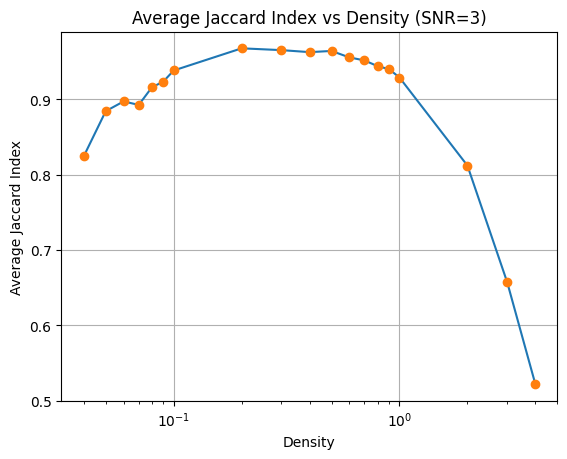

In [5]:
# Plot the dict with densities (keys) on the x-axis and the average ji on on the y-axis
import matplotlib.pyplot as plt
densities = np.array(list(denseresults5snr.keys()))
average_jis = np.array([denseresults5snr[density]['mean_ji'] for density in densities])

plt.plot(densities, average_jis)
plt.semilogx(densities, average_jis, marker='o', linestyle='None')  # log x-axis, scatter style

plt.xlabel('Density')
plt.ylabel('Average Jaccard Index')
plt.title('Average Jaccard Index vs Density (SNR=3)')
plt.xlim(0, 5)
plt.grid()
plt.show()

In [18]:
print(denseresults3snr[0.04].keys())

dict_keys(['mean_precision', 'mean_recall', 'mean_f1', 'mean_ji', 'mean_loc_error', 'avg_std_loc_error', 'mean_mean_squared_error', 'avg_std_mean_squared_error', 'std_precision', 'std_recall', 'std_f1', 'std_ji', 'std_loc_error', 'std_mean_squared_error'])


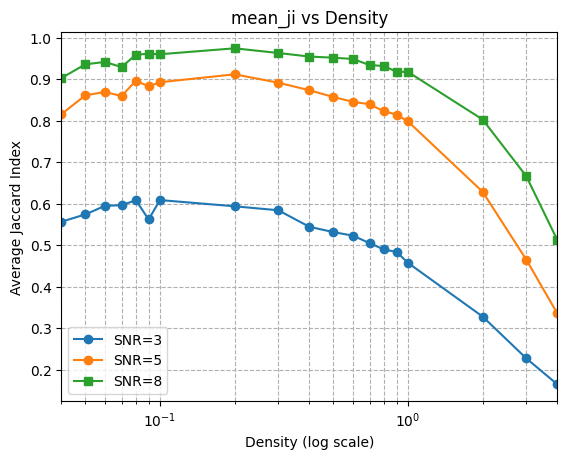

In [6]:
metric = 'mean_ji'
densities3 = np.array(list(denseresults3snr.keys()))
average_jis3 = np.array([denseresults3snr[density][metric] for density in densities3])
densities5 = np.array(list(denseresults5snr.keys()))
average_jis5 = np.array([denseresults5snr[density][metric] for density in densities5])
densities8 = np.array(list(denseresults8snr.keys()))
average_jis8 = np.array([denseresults8snr[density][metric] for density in densities8])

plt.semilogx(densities3, average_jis3, marker='o', linestyle='-', label='SNR=3')
plt.semilogx(densities5, average_jis5, marker='o', linestyle='-', label='SNR=5')
plt.semilogx(densities8, average_jis8, marker='s', linestyle='-', label='SNR=8')

plt.xlabel('Density (log scale)')
plt.ylabel('Average Jaccard Index')
plt.title(f'{metric} vs Density')
plt.xlim(min(densities3.min(), densities8.min()), max(densities3.max(), densities8.max()))
plt.grid(True, which="both", ls="--")
plt.legend()
plt.show()

In [ ]:
densities3 = np.array(list(denseresults3snr.keys()))
average_jis3 = np.array([denseresults3snr[density]['avg ji'] for density in densities3])
densities5 = np.array(list(denseresults5snr.keys()))
average_jis5 = np.array([denseresultssnr[density]['avg ji'] for density in densities5])
densities8 = np.array(list(denseresults8snr.keys()))
average_jis8 = np.array([denseresults8snr[density]['avg ji'] for density in densities8])

plt.semilogx(densities3, average_jis3, marker='o', linestyle='-', label='SNR=3')
#plt.semilogx(densities5, average_jis5, marker='o', linestyle='-', label='SNR=3')
plt.semilogx(densities8, average_jis8, marker='s', linestyle='-', label='SNR=8')

plt.xlabel('Density (log scale)')
plt.ylabel('Average Jaccard Index')
plt.title('Average Jaccard Index vs Density')
plt.xlim(min(densities3.min(), densities8.min()), max(densities3.max(), densities8.max()))
plt.grid(True, which="both", ls="--")
plt.legend()
plt.show()

KeyError: 'avg ji'

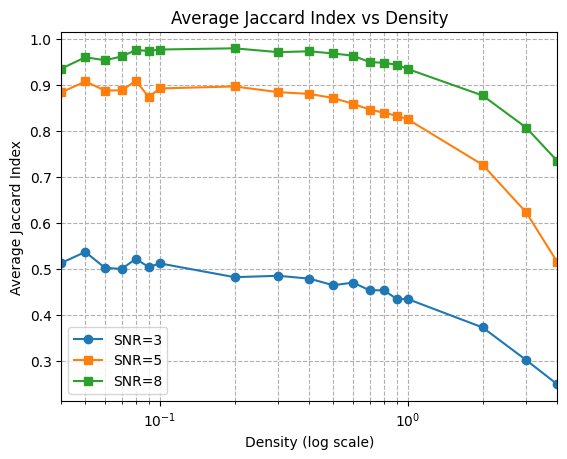

In [11]:
densities3 = np.array(list(denseresults3snr.keys()))
average_jis3 = np.array([denseresults3snr[density]['avg ji'] for density in densities3])
densities5 = np.array(list(denseresults5snr.keys()))
average_jis5 = np.array([denseresults5snr[density]['avg ji'] for density in densities5])
densities8 = np.array(list(denseresults8snr.keys()))
average_jis8 = np.array([denseresults8snr[density]['avg ji'] for density in densities8])

plt.semilogx(densities3, average_jis3, marker='o', linestyle='-', label='SNR=3')
plt.semilogx(densities5, average_jis5, marker='s', linestyle='-', label='SNR=5')
plt.semilogx(densities8, average_jis8, marker='s', linestyle='-', label='SNR=8')

plt.xlabel('Density (log scale)')
plt.ylabel('Average Jaccard Index')
plt.title('Average Jaccard Index vs Density')
plt.xlim(min(densities3.min(), densities8.min()), max(densities3.max(), densities8.max()))
plt.grid(True, which="both", ls="--")
plt.legend()
plt.show()

In [14]:
save_path = r'D:\zeiss\Desktop\coding\Hilger\bachelor\measurements\draft_measurements\iou05\recallvssnr_iou05.pkl'
with open(save_path, 'wb') as f:
    pickle.dump(result05, f)

AttributeError: Can't get local object 'evaluate_recall_per_snr.<locals>.<lambda>'

In [8]:
import pickle

In [14]:
print(type(result))

<class 'tuple'>


In [13]:
params = {'snr_min': 1, 'snr_max': 10}
result05 = evaluate_recall_per_snr(model, 20000, device, 0.5, **params)


Processing image 1/20000
Processing image 101/20000
Processing image 201/20000
Processing image 301/20000
Processing image 401/20000
Processing image 501/20000
Processing image 601/20000
Processing image 701/20000
Processing image 801/20000
Processing image 901/20000
Processing image 1001/20000
Processing image 1101/20000
Processing image 1201/20000
Processing image 1301/20000
Processing image 1401/20000
Processing image 1501/20000
Processing image 1601/20000
Processing image 1701/20000
Processing image 1801/20000
Processing image 1901/20000
Processing image 2001/20000
Processing image 2101/20000
Processing image 2201/20000
Processing image 2301/20000
Processing image 2401/20000
Processing image 2501/20000
Processing image 2601/20000
Processing image 2701/20000
Processing image 2801/20000
Processing image 2901/20000
Processing image 3001/20000
Processing image 3101/20000
Processing image 3201/20000
Processing image 3301/20000
Processing image 3401/20000
Processing image 3501/20000
Proc

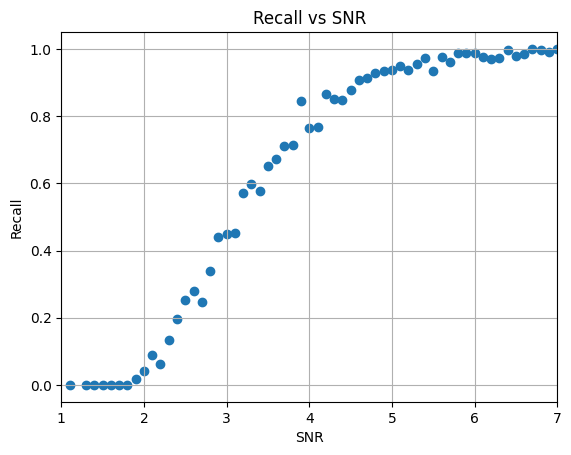

In [20]:

snrs = np.array(list(result05[0].keys()))
recalls = np.array([result05[0][snr]['TP'] / (result05[0][snr]['TP'] + result05[0][snr]['FN']) for snr in snrs])
plt.scatter(snrs, recalls)
plt.xlabel('SNR')
plt.ylabel('Recall')
plt.title('Recall vs SNR')
plt.xlim(1,7)
plt.grid()
plt.show()


In [27]:
save_path = r'D:\zeiss\Desktop\coding\Hilger\bachelor\measurements\draft_measurements\iou05\recallvssnr_iou05.pkl'
with open(save_path, 'wb') as f:
    pickle.dump((dict(result05[0]), dict(result05[1])), f)

In [25]:
print(type(dict(result05[0])))

<class 'dict'>


In [29]:
import pickle

load_path = r'D:\zeiss\Desktop\coding\Hilger\bachelor\measurements\draft_measurements\iou05\recallvssnr_iou05.pkl'
with open(load_path, 'rb') as f:
    loaded_object = pickle.load(f)

# Testing noise levels

In [5]:
noisetest_snr5 = test_perlinnoise_fixed_snr(model, snr=5, num_images=300, device=device)

0.5
Noise level: (0.0, 1.0), Metrics: {'mean_precision': np.float64(0.9014948323202799), 'mean_recall': np.float64(0.8416666666666668), 'mean_f1': np.float64(0.8694876849080906), 'mean_ji': np.float64(0.7797767419625741), 'mean_loc_error': np.float64(0.26175926844724445), 'avg_std_loc_error': np.float64(0.1249119822140668), 'mean_mean_squared_error': np.float64(0.08560665492193953), 'avg_std_mean_squared_error': np.float64(0.07214696674164064), 'std_precision': np.float64(0.08073633931859664), 'std_recall': np.float64(0.10278078073691056), 'std_f1': np.float64(0.08923093323431919), 'std_ji': np.float64(0.13570578483770687), 'std_loc_error': np.float64(0.0333244929499644), 'std_mean_squared_error': np.float64(0.019687435614483394)}
0.5
Noise level: (0.05, 0.95), Metrics: {'mean_precision': np.float64(0.8948984532409455), 'mean_recall': np.float64(0.8421666666666667), 'mean_f1': np.float64(0.8667622454586511), 'mean_ji': np.float64(0.775289665246187), 'mean_loc_error': np.float64(0.26060

In [10]:
noisetest_snr3 = test_perlinnoise_fixed_snr(model, snr=3, num_images=300, device=device)
noisetest_snr2 = test_perlinnoise_fixed_snr(model, snr=2, num_images=300, device=device)
noisetest_snr8 = test_perlinnoise_fixed_snr(model, snr=8, num_images=300, device=device)

0.5
Noise level: (0.0, 1.0), Metrics: {'mean_precision': np.float64(0.6832761601716709), 'mean_recall': np.float64(0.5239999999999999), 'mean_f1': np.float64(0.5890537182411583), 'mean_ji': np.float64(0.4311770235084835), 'mean_loc_error': np.float64(0.31670164319443594), 'avg_std_loc_error': np.float64(0.13049049291742698), 'mean_mean_squared_error': np.float64(0.1198966158063972), 'avg_std_mean_squared_error': np.float64(0.08372053784200084), 'std_precision': np.float64(0.13744673284046302), 'std_recall': np.float64(0.14459368358726232), 'std_f1': np.float64(0.1380851744914606), 'std_ji': np.float64(0.14108124922180204), 'std_loc_error': np.float64(0.04347663871668912), 'std_mean_squared_error': np.float64(0.028377981527948865)}


d:\zeiss\Desktop\coding\Hilger\bachelor\PsfSimulator.py:122: RuntimeWarning: All-NaN slice encountered
  signal = np.nanmax(array[y1:y2, x1:x2])


0.5
Noise level: (0.05, 0.95), Metrics: {'mean_precision': np.float64(0.6747695442099467), 'mean_recall': np.float64(0.5265), 'mean_f1': np.float64(0.5877884839778613), 'mean_ji': np.float64(0.42922726879428524), 'mean_loc_error': np.float64(0.3198634500720239), 'avg_std_loc_error': np.float64(0.12983856833085175), 'mean_mean_squared_error': np.float64(0.1219851999787069), 'avg_std_mean_squared_error': np.float64(0.0841507635296707), 'std_precision': np.float64(0.13232634520769038), 'std_recall': np.float64(0.14284986290974638), 'std_f1': np.float64(0.13640844080423092), 'std_ji': np.float64(0.13592251869789646), 'std_loc_error': np.float64(0.04529025692193957), 'std_mean_squared_error': np.float64(0.030212832672934734)}
0.5
Noise level: (0.1, 0.9), Metrics: {'mean_precision': np.float64(0.6957145979092574), 'mean_recall': np.float64(0.55), 'mean_f1': np.float64(0.6108013452859516), 'mean_ji': np.float64(0.4526604307324822), 'mean_loc_error': np.float64(0.3221100518665941), 'avg_std_lo

c:\Users\zeiss\anaconda3\envs\hilger312\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\zeiss\anaconda3\envs\hilger312\Lib\site-packages\numpy\_core\_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\zeiss\anaconda3\envs\hilger312\Lib\site-packages\numpy\_core\_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\zeiss\anaconda3\envs\hilger312\Lib\site-packages\numpy\_core\_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\zeiss\anaconda3\envs\hilger312\Lib\site-packages\numpy\_core\_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Noise level: (0.0, 1.0), Metrics: {'mean_precision': np.float64(0.4898537342287343), 'mean_recall': np.float64(0.20700000000000002), 'mean_f1': np.float64(0.28345860884186336), 'mean_ji': np.float64(0.17265386803603583), 'mean_loc_error': np.float64(nan), 'avg_std_loc_error': np.float64(nan), 'mean_mean_squared_error': np.float64(nan), 'avg_std_mean_squared_error': np.float64(nan), 'std_precision': np.float64(0.1962033726631458), 'std_recall': np.float64(0.11225417586887358), 'std_f1': np.float64(0.13655362310066846), 'std_ji': np.float64(0.09500700359696719), 'std_loc_error': np.float64(nan), 'std_mean_squared_error': np.float64(nan)}
0.5
Noise level: (0.05, 0.95), Metrics: {'mean_precision': np.float64(0.5158942585192585), 'mean_recall': np.float64(0.225), 'mean_f1': np.float64(0.3052419274221842), 'mean_ji': np.float64(0.1878554489784375), 'mean_loc_error': np.float64(nan), 'avg_std_loc_error': np.float64(nan), 'mean_mean_squared_error': np.float64(nan), 'avg_std_mean_squared_error'

In [7]:
print(noisetest_snr5)

{(0.0, 1.0): {'mean_precision': np.float64(0.9014948323202799), 'mean_recall': np.float64(0.8416666666666668), 'mean_f1': np.float64(0.8694876849080906), 'mean_ji': np.float64(0.7797767419625741), 'mean_loc_error': np.float64(0.26175926844724445), 'avg_std_loc_error': np.float64(0.1249119822140668), 'mean_mean_squared_error': np.float64(0.08560665492193953), 'avg_std_mean_squared_error': np.float64(0.07214696674164064), 'std_precision': np.float64(0.08073633931859664), 'std_recall': np.float64(0.10278078073691056), 'std_f1': np.float64(0.08923093323431919), 'std_ji': np.float64(0.13570578483770687), 'std_loc_error': np.float64(0.0333244929499644), 'std_mean_squared_error': np.float64(0.019687435614483394)}, (0.05, 0.95): {'mean_precision': np.float64(0.8948984532409455), 'mean_recall': np.float64(0.8421666666666667), 'mean_f1': np.float64(0.8667622454586511), 'mean_ji': np.float64(0.775289665246187), 'mean_loc_error': np.float64(0.2606036420729681), 'avg_std_loc_error': np.float64(0.12

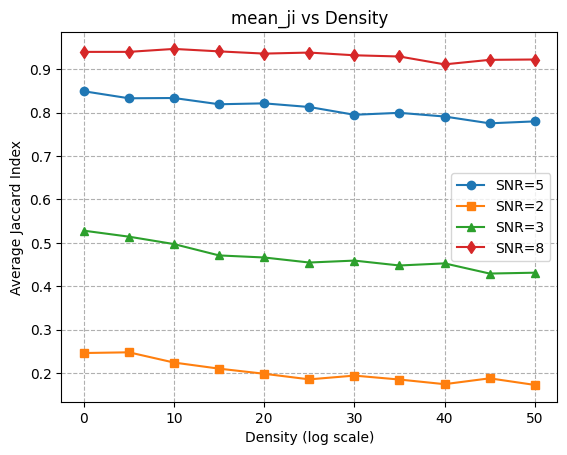

In [12]:
metric = 'mean_ji'
l5 = np.array(list(noisetest_snr5.keys()))
l2 = np.array(list(noisetest_snr2.keys()))
l3 = np.array(list(noisetest_snr3.keys()))
l8 = np.array(list(noisetest_snr8.keys()))

x = np.arange(50, -1, -5)
m5 = np.array([noisetest_snr5[tuple(noise)][metric] for noise in l5])
m2 = np.array([noisetest_snr2[tuple(noise)][metric] for noise in l2])
m3 = np.array([noisetest_snr3[tuple(noise)][metric] for noise in l3])
m8 = np.array([noisetest_snr8[tuple(noise)][metric] for noise in l8])

plt.plot(x, m5, marker='o', linestyle='-',label='SNR=5')
plt.plot(x, m2, marker='s', linestyle='-',label='SNR=2')
plt.plot(x, m3, marker='^', linestyle='-',label='SNR=3')
plt.plot(x, m8, marker='d', linestyle='-',label='SNR=8')
plt.xlabel('Density (log scale)')
plt.ylabel('Average Jaccard Index')
plt.title(f'{metric} vs Density')
plt.grid(True, which="both", ls="--")
plt.legend()
plt.show()

In [15]:
save_path = r'D:\zeiss\Desktop\coding\Hilger\bachelor\measurements\draft_measurements\iou05\noisetest_8snr.pkl'
with open(save_path, 'wb') as f:
    pickle.dump(noisetest_snr8, f)